# Project 4 - Matt Sloan

## Introduce the problem
Introduce the project. What is the problem you are trying to solve? What questions are you trying to find answer

https://www.kaggle.com/datasets/cisautomotiveapi/large-car-dataset/download?datasetVersionNumber=4 (warning: large file)   
from 
https://www.kaggle.com/datasets/cisautomotiveapi/large-car-dataset
## Create ipynb template for website -darkmode html command, set low jpg, ignore warnings, default imports numpy pandas traintest

I'm looking to see if there are specific specific features that tend to make vehicles more fuel efficient. We all know that having a smaller engine inherently means higher mpg's... or does it?
What other factors tend to be at play here? Does one manufacturer tend to specialize in this? Bonus... what cars tend to have the best price/mpg ratio?

## What is clustering and how does it work?

With supervised machine learning, you always have a target that you're looking for and you will have an output from your particular algorithm to compare to.   
Clustering is *unsupervised* machine learning. In other words, you will **NOT** have a target to compare to. It does not *predict* anything. Instead, clustering is useful for breaking down your data samples into groups.   
It might be helpful in some cases to categorize based on overall similarities.   
   
In order to explain what the k-means algorithm does, imagine that one could plot one data-point vs another. If these were numerical values, you could plot all of these on the same plane. If we were to look at phone battery life vs phone price, we could end up with a plot that has several obvious groups, or clusters, of phones plotted. K-means takes a number, k, to determine how many clusters to look for. Then it tries to find a combination of k number of phones in k groups, with each group only containing the phones that were closest to it. This is a simple example, but most datasets have more than 2 variables!

## Introduce the data
Where did you find it? What is the data about (include links)? What are the features (with additional explanations if not already self-explanatory from the name itself)?

I was looking for mpg data for vehicles that was also paired with msrp. I decided to use the [dataset from fueleconomy.gov](https://fueleconomy.gov/feg/download.shtml) for mpg values and [this... 5gb dataset from kaggle.](https://www.kaggle.com/datasets/cisautomotiveapi/large-car-dataset) for vehicle info.   
It appears to be a sample of AutoDealerData.com of vehicle listings from Illinois from June 2018 until 2020.   
I will probably remove duplicates in an attempt to save my RAM from annihilation.   
This dataset has 156 features and ~5.7 million entries.
The features that I am most interested in are:   
* msrp
* brandName
* modelName
* bodyClass
* DisplacementCC
* Doors
* DriveType
* EngineCylcinders
* EngineManufacturer
* MakeID
* Manufacturer
* Model
* ModelYear
* Turbo
* TransissionSpeeds
* TransmissionStyle   
However I will be utilizing most of the remaining features as well.   
---
   
And from the fueleconomy.gov dataset, I will be using:
* comb08 - combined MPG from fueltype 1 (I will be assuming the primary fuel type is normally used)
* make - manufacturer (division)
* mfrCode - 3-character manufacturer code
* model - model name (carline)
* year - model year
* displ - engine displacement in liters   
   
I intend to use these variables to accurately append the combined mpg to the vehicle

## Data Understanding/Visualization
Use methods to try to further understand and visualize the data. Make sure to remember your initial problems/questions when completing this step.
While exploring, does anything else stand out to you (perhaps any surprising insights?)

**How does this step relate to your modeling?**

Let us start out by loading the file.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='jpg'
sns.set(rc={"figure.figsize":(10, 10)})
sns.set(rc={"figure.dpi": 100})

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
# these are the columns we need to keep
main_df_colms = ['brandName',
            'modelName',
            'vf_BodyClass',
            'vf_FuelInjectionType',
            'vf_Manufacturer',
            'vf_PlantCity',
            'vf_PlantCompanyName',
            'vf_PlantCountry',
            'vf_PlantState',
            'vf_Series',
            'vf_TransmissionSpeeds',
            'vf_TransmissionStyle',
            'vf_Trim',
            'vf_Turbo',
            'vf_DisplacementL',
            'vf_Doors',
            'vf_ModelID',
            'vf_ModelYear',
       ]
main_df_cats = ['brandName',
               'modelName',
               'vf_BodyClass',
               'vf_FuelInjectionType',
               'vf_Manufacturer',
               'vf_PlantCity',
               'vf_PlantCompanyName',
               'vf_PlantCountry',
               'vf_PlantState',
               'vf_Series',
               'vf_Doors'
]

mpg_df_colms = ['comb08',
                    'make',
                    'mfrCode',
                    'model',
                    'year',
                    'displ',
                    'cylinders'
                    ]
mpg_df_cats = ['make',
               'model']

# main working df
main_df = pd.DataFrame()
# temp df for mpg data
mpg_df = pd.DataFrame()

######### Since I have already saved these as parquets... 

# main_df
main_df = pd.read_parquet('data/archive/CIS_Automotive_Kaggle_Sample.parquet',
                              columns=main_df_colms,
                              use_nullable_dtypes = True)
                              
main_df = main_df.replace(to_replace = '', value = pd.NA)
main_df[main_df_cats] = main_df[main_df_cats].astype(dtype=pd.CategoricalDtype())

# mpg df
mpg_df = pd.read_parquet('data/archive/vehicles.parquet',
                              columns=mpg_df_colms,
                              use_nullable_dtypes = True)

mpg_df = mpg_df.replace(to_replace = '', value = pd.NA)
mpg_df[mpg_df_cats] = mpg_df[mpg_df_cats].astype(dtype=pd.CategoricalDtype())

I had some issues trying to read it in chunks, so I chose which columns were the most important and loaded only those. Most columns had a large quantity of missing values anyways :(

In [3]:
main_df.head()

,brandName,modelName,vf_BodyClass,vf_FuelInjectionType,vf_Manufacturer,vf_PlantCity,vf_PlantCompanyName,vf_PlantCountry,vf_PlantState,vf_Series,vf_TransmissionSpeeds,vf_TransmissionStyle,vf_Trim,vf_Turbo,vf_DisplacementL,vf_Doors,vf_ModelID,vf_ModelYear
0,MITSUBISHI,Eclipse Spyder,Convertible/Cabriolet,Multipoint Fuel Injection (MPFI),MITSUBISHI MOTORS NORTH AMERICA,BLOOMINGTON-NORMAL,<NA>,UNITED STATES (USA),ILLINOIS,SPORTS,<NA>,<NA>,<NA>,<NA>,3.0,2.0,2321.0,2002.0
1,NISSAN,Altima,Sedan/Saloon,<NA>,NISSAN NORTH AMERICA INC,CANTON,Nissan North America Inc.,UNITED STATES (USA),MISSISSIPPI,<NA>,<NA>,<NA>,<NA>,<NA>,2.5,4.0,1904.0,2016.0
2,FORD,Escape,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,Stoichiometric gasoline direct injection (SGDI),FORD MOTOR COMPANY USA,LOUISVILLE,Louisville Assembly,UNITED STATES (USA),KENTUCKY,SE,<NA>,<NA>,<NA>,<NA>,1.6,4.0,1798.0,2014.0
3,CHEVROLET,Cruze,Sedan/Saloon,<NA>,GENERAL MOTORS LLC,LORDSTOWN,GMNA,UNITED STATES (USA),OHIO,Premier,<NA>,Automatic,<NA>,Yes,1.4,4.0,1832.0,2017.0
4,FORD,F-150,Pickup,<NA>,FORD MOTOR COMPANY USA,DEARBORN,Dearborn,UNITED STATES (USA),MICHIGAN,<NA>,<NA>,Automatic,<NA>,<NA>,5.0,<NA>,1801.0,2019.0


In [4]:
mpg_df.head()

,comb08,make,mfrCode,model,year,displ,cylinders
0,21,Alfa Romeo,<NA>,Spider Veloce 2000,1985,2.0,4.0
1,11,Ferrari,<NA>,Testarossa,1985,4.9,12.0
2,27,Dodge,<NA>,Charger,1985,2.2,4.0
3,11,Dodge,<NA>,B150/B250 Wagon 2WD,1985,5.2,8.0
4,19,Subaru,<NA>,Legacy AWD Turbo,1993,2.2,4.0


In [5]:
main_df.describe()

,vf_TransmissionSpeeds,vf_DisplacementL,vf_ModelID,vf_ModelYear
count,1293522.0,5648866.0,5689172.0,5693733.0
mean,6.894028,3.295728,3716.957589,2015.304548
std,1.390092,6.486849,4513.854753,4.613182
min,1.0,0.0,1684.0,1980.0
25%,6.0,2.0,1847.0,2014.0
50%,6.0,2.5,1945.0,2017.0
75%,8.0,3.6,2735.0,2019.0
max,10.0,200.0,27897.0,2021.0


In [6]:
mpg_df.describe()

,comb08,year,displ,cylinders
count,45777.0,45777.0,45313.0,45311.0
mean,21.290932,2003.558031,3.280399,5.709916
std,9.637874,12.165146,1.356625,1.772264
min,7.0,1984.0,0.0,2.0
25%,17.0,1992.0,2.2,4.0
50%,20.0,2005.0,3.0,6.0
75%,23.0,2014.0,4.2,6.0
max,142.0,2023.0,8.4,16.0


Nulls?

In [7]:
print("---------------- main df ----------------")

for col in main_df.columns:
    if main_df[col].isnull().sum() > 0:
        print(f'{round(((main_df[col].isnull().sum()/main_df.shape[0])*100),2)}% -----{main_df[col].isnull().sum()} null values in {col}')
        
print("\n---------------- mpg df ----------------")

for col in mpg_df.columns:
    if mpg_df[col].isnull().sum() > 0:
        print(f'{round(((mpg_df[col].isnull().sum()/mpg_df.shape[0])*100),2)}% -----{mpg_df[col].isnull().sum()} null values in {col}')

---------------- main df ----------------
0.02% -----1260 null values in brandName
0.1% -----5843 null values in modelName
0.2% -----11559 null values in vf_BodyClass
75.4% -----4293878 null values in vf_FuelInjectionType
0.02% -----1260 null values in vf_Manufacturer
10.79% -----614448 null values in vf_PlantCity
27.44% -----1562812 null values in vf_PlantCompanyName
3.13% -----178494 null values in vf_PlantCountry
26.74% -----1522665 null values in vf_PlantState
24.66% -----1404119 null values in vf_Series
77.29% -----4401493 null values in vf_TransmissionSpeeds
66.21% -----3770877 null values in vf_TransmissionStyle
60.5% -----3445574 null values in vf_Trim
78.82% -----4488758 null values in vf_Turbo
0.81% -----46149 null values in vf_DisplacementL
13.71% -----780801 null values in vf_Doors
0.1% -----5843 null values in vf_ModelID
0.02% -----1282 null values in vf_ModelYear

---------------- mpg df ----------------
67.3% -----30808 null values in mfrCode
1.01% -----464 null values i

Collinearity?

C:\Users\Matt\AppData\Local\Temp\ipykernel_10712\484303362.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(main_df.corr(), cmap="YlGnBu", annot=True, fmt='.1g')


<AxesSubplot: >

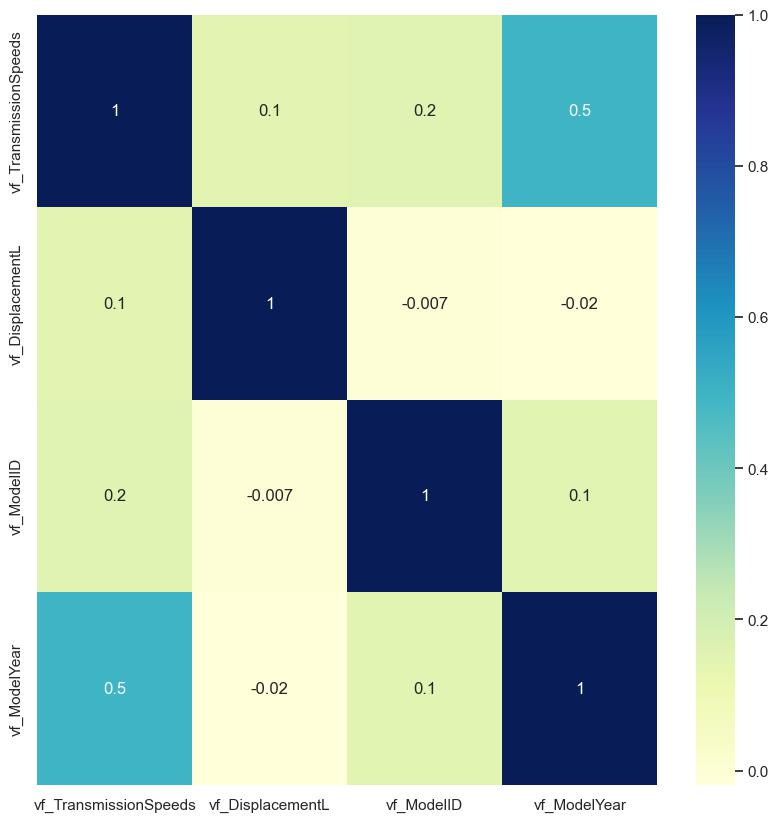

In [8]:
sns.heatmap(main_df.corr(), cmap="YlGnBu", annot=True, fmt='.1g')

C:\Users\Matt\AppData\Local\Temp\ipykernel_10712\1963279787.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(mpg_df.drop(['comb08'], axis=1).corr(), cmap="YlGnBu", annot=True, fmt='.1g')


<AxesSubplot: >

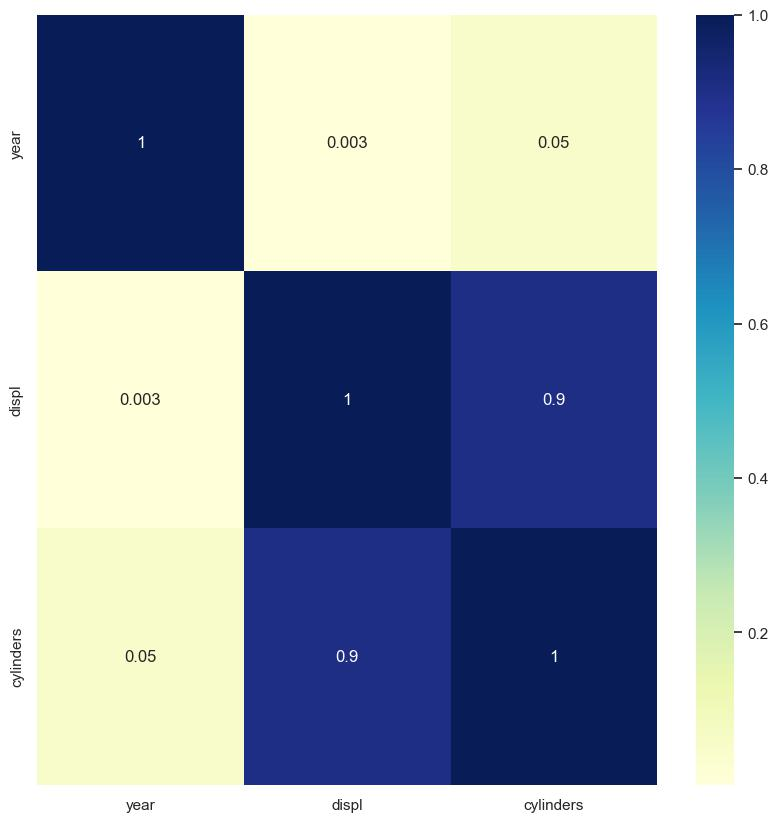

In [9]:
sns.heatmap(mpg_df.drop(['comb08'], axis=1).corr(), cmap="YlGnBu", annot=True, fmt='.1g')

## Pre-processing the data
What pre-processing steps do you follow? Explain why you do each pre-processing step.

First I want to remove colms with a large number of missing values. Let's remove columns missing 10% or more.

In [10]:
print("---------------- main df ----------------")

for col in main_df.columns:
    if main_df[col].isnull().sum()/main_df.shape[0] > 0.10:
        del main_df[col]
    else:
        print(f'{round(((main_df[col].isnull().sum()/main_df.shape[0])*100),2)}% -----{main_df[col].isnull().sum()} null values in {col}')
        
print("\n---------------- mpg df ----------------")

for col in mpg_df.columns:
    if mpg_df[col].isnull().sum()/mpg_df.shape[0] > 0.10:
        del mpg_df[col]
    else:
        print(f'{round(((mpg_df[col].isnull().sum()/mpg_df.shape[0])*100),2)}% -----{mpg_df[col].isnull().sum()} null values in {col}')

---------------- main df ----------------
0.02% -----1260 null values in brandName
0.1% -----5843 null values in modelName
0.2% -----11559 null values in vf_BodyClass
0.02% -----1260 null values in vf_Manufacturer
3.13% -----178494 null values in vf_PlantCountry
0.81% -----46149 null values in vf_DisplacementL
0.1% -----5843 null values in vf_ModelID
0.02% -----1282 null values in vf_ModelYear

---------------- mpg df ----------------
0.0% -----0 null values in comb08
0.0% -----0 null values in make
0.0% -----0 null values in model
0.0% -----0 null values in year
1.01% -----464 null values in displ
1.02% -----466 null values in cylinders


Now we'll rid of rows with missing values

In [11]:
main_original_size = main_df.shape
mpg_original_size = mpg_df.shape


main_df = main_df.dropna()
mpg_df = mpg_df.dropna()

In [12]:
print(f'main df shape: {main_df.shape} and main df is now {round(main_df.shape[0]/main_original_size[0],3)*100}% of the original size ({main_original_size}).')
print(f'mpg df shape: {mpg_df.shape} and mpg df is now {round(mpg_df.shape[0]/mpg_original_size[0],3)*100}% of the original size ({mpg_original_size}).')

main df shape: (5466424, 8) and main df is now 96.0% of the original size ((5695015, 8)).
mpg df shape: (45311, 6) and mpg df is now 99.0% of the original size ((45777, 6)).


Now since our goal is to classify vehicle features that are associated with higher mpg values, I will bin mpg into sets of 5 with higher values being higher mpg values

In [13]:
mpg_df['binned_mpg'] = mpg_df['comb08'].apply(lambda x: (5 * round(x/5))/5).astype(np.int32)

In [14]:
# also round the engine displacement
main_df['vf_DisplacementL'] = main_df['vf_DisplacementL'].round(decimals=1)
mpg_df['displ'] = mpg_df['displ'].round(decimals=1)

Finally, before we merge our df's let us remove some duplicate rows.

In [15]:
main_df = main_df.drop_duplicates()
print(main_df.shape)

(15149, 8)


Let's check it out :)

In [16]:
main_df.loc[(main_df['brandName']=='FORD') & (main_df['modelName'] == 'Explorer')]

,brandName,modelName,vf_BodyClass,vf_Manufacturer,vf_PlantCountry,vf_DisplacementL,vf_ModelID,vf_ModelYear
8,FORD,Explorer,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,FORD MOTOR COMPANY USA,UNITED STATES (USA),3.5,1800.0,2018.0
17,FORD,Explorer,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,FORD MOTOR COMPANY USA,UNITED STATES (USA),3.5,1800.0,2013.0
32,FORD,Explorer,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,FORD MOTOR COMPANY USA,UNITED STATES (USA),3.5,1800.0,2017.0
61,FORD,Explorer,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,FORD MOTOR COMPANY USA,UNITED STATES (USA),3.5,1800.0,2016.0
77,FORD,Explorer,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,FORD MOTOR COMPANY USA,UNITED STATES (USA),3.5,1800.0,2015.0
...,...,...,...,...,...,...,...,...
998646,FORD,Explorer,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,FORD MOTOR COMPANY USA,UNITED STATES (USA),5.0,1800.0,2001.0
1237656,FORD,Explorer,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,FORD MOTOR COMPANY USA,UNITED STATES (USA),3.7,1800.0,2017.0
1249149,FORD,Explorer,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,FORD MOTOR COMPANY USA,UNITED STATES (USA),4.0,1800.0,1994.0
1252812,FORD,Explorer,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,FORD MOTOR COMPANY USA,UNITED STATES (USA),4.0,1800.0,1993.0


Also our mpg df has high collinearity between cylinders and displacement... surprise! (90%!)
So let's see if we can reduce some of that collinearity by replacing cylinders with displacement per cyclinder - dpc

In [17]:
mpg_df['disp_per_cyl'] = mpg_df['displ']/mpg_df['cylinders']
del mpg_df['cylinders']

C:\Users\Matt\AppData\Local\Temp\ipykernel_10712\183663411.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(mpg_df.drop(['comb08'], axis = 1).corr(), cmap="YlGnBu", annot=True, fmt='.1g')


<AxesSubplot: >

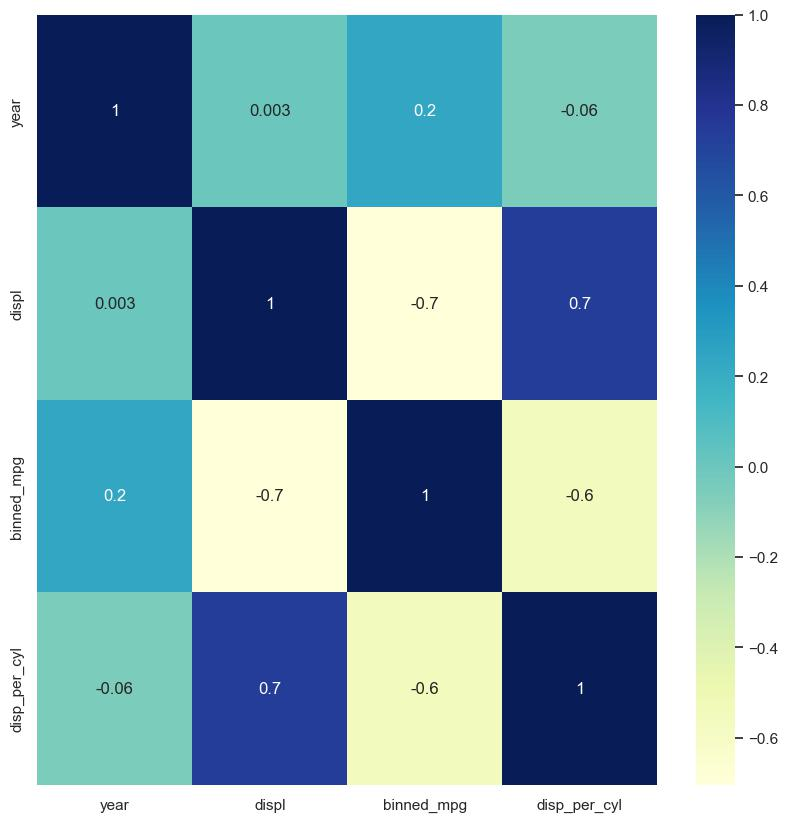

In [18]:
sns.heatmap(mpg_df.drop(['comb08'], axis = 1).corr(), cmap="YlGnBu", annot=True, fmt='.1g')

70% is better I suppose...
   
   
Time to add our mpg values to our main df.   
1) make sure brand name/manufacterur and model name are same case so we can match them
2) rename our mpg_df columns so that we can inner join

In [19]:
# set these column names to lowercase so it's easier to match (for me)
main_df['brandName'] = main_df['brandName'].str.lower()
main_df['modelName'] = main_df['modelName'].str.lower()

mpg_df['make'] = mpg_df['make'].str.lower()
mpg_df['model'] = mpg_df['model'].str.lower()

In [20]:
# rename the columns in the other df so they can match with the main df
mpg_df.rename(columns = {'year': 'vf_ModelYear', 'model': 'modelName', 'make': 'brandName', 'displ': 'vf_DisplacementL'}, inplace = True)

In [21]:
# shape of our old df?
main_df.shape

(15149, 8)

In [22]:
# inner join (merge) by default - our matching columns will be our 'lock and key' to make sure our 'other' column(s) get combined
comb_df = main_df.merge(mpg_df)

In [23]:
# shape of our new df?
comb_df.shape

(9419, 11)

In [24]:
comb_df.head()

,brandName,modelName,vf_BodyClass,vf_Manufacturer,vf_PlantCountry,vf_DisplacementL,vf_ModelID,vf_ModelYear,comb08,binned_mpg,disp_per_cyl
0,mitsubishi,eclipse spyder,Convertible/Cabriolet,MITSUBISHI MOTORS NORTH AMERICA,UNITED STATES (USA),3.0,2321.0,2002.0,21,4,0.5
1,mitsubishi,eclipse spyder,Convertible/Cabriolet,MITSUBISHI MOTORS NORTH AMERICA,UNITED STATES (USA),3.0,2321.0,2002.0,20,4,0.5
2,nissan,altima,Sedan/Saloon,NISSAN NORTH AMERICA INC,UNITED STATES (USA),2.5,1904.0,2016.0,31,6,0.625
3,chevrolet,cruze,Sedan/Saloon,GENERAL MOTORS LLC,UNITED STATES (USA),1.4,1832.0,2017.0,34,7,0.35
4,chevrolet,cruze,Sedan/Saloon,GENERAL MOTORS LLC,UNITED STATES (USA),1.4,1832.0,2017.0,32,6,0.35


In [25]:
# a little bit of code that lists all of the models for each manufacturer in our dataset :)

# for make in comb_df['brandName'].unique():
#     print(make, comb_df.loc[comb_df['brandName'] == make]['modelName'].unique(), '\n')

## Modeling (Clustering)
What model(s) do you use to try to solve your problem? Why do you choose those model(s)?

I will use random forests to predict mpg of a vechile. I believe that engine displacement will have high multicollinearity so I will try it both with and without.   
As for clustering: I will be using k-means clustering to add another feature to the dataset in an attempt to increase the accuracy of the random forest model. My goal with this is to see which feature sets are consistently associated with higher mpg values.    
---
Let us get a baseline model!   
1) we'll dummy variable every 'object' field
2) standardize our data
3) train test split 80/20
4) rf with n_estimators = 30
5) compute our baseline score

In [26]:
x = comb_df.drop(['comb08','binned_mpg'], axis = 1)
y = comb_df['binned_mpg']

In [27]:
x.corr()

C:\Users\Matt\AppData\Local\Temp\ipykernel_10712\2976989851.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x.corr()


,vf_DisplacementL,vf_ModelID,vf_ModelYear,disp_per_cyl
vf_DisplacementL,1.000000,-0.009071,-0.050101,0.749481
vf_ModelID,-0.009071,1.000000,-0.142927,-0.027157
vf_ModelYear,-0.050101,-0.142927,1.000000,-0.055771
disp_per_cyl,0.749481,-0.027157,-0.055771,1.000000


C:\Users\Matt\AppData\Local\Temp\ipykernel_10712\3479505415.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(x.corr(), cmap="YlGnBu", annot=True, fmt='.1g')


<AxesSubplot: >

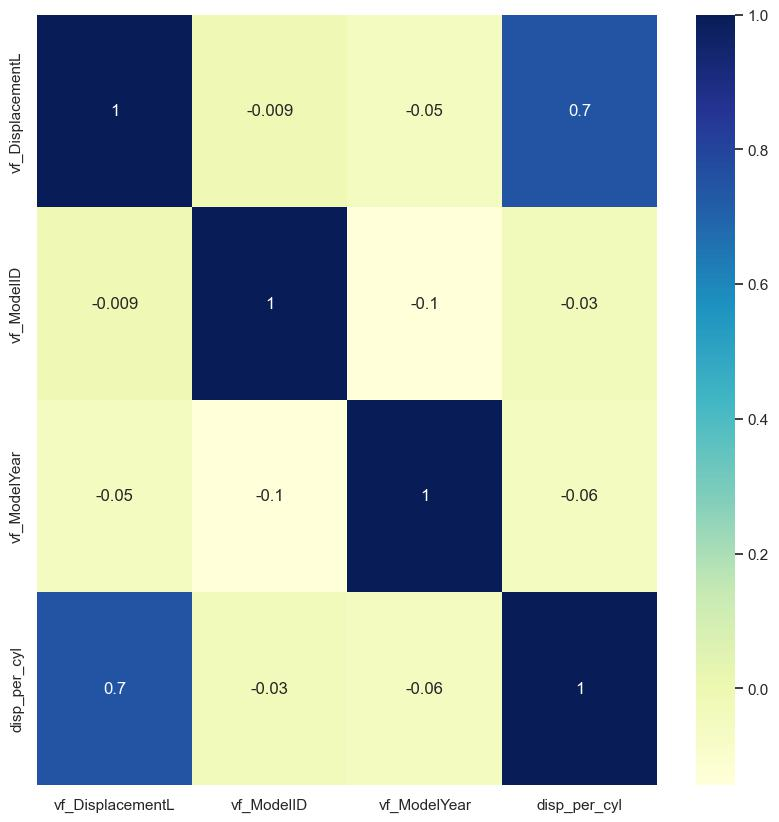

In [28]:
sns.heatmap(x.corr(), cmap="YlGnBu", annot=True, fmt='.1g')

Let's add our dummies

In [29]:
dummy_colms = [colm for colm in x.columns if x[colm].dtype == 'object' or x[colm].dtype == 'string' or x[colm].dtype == 'category'] # some fancy list comprehension. Good practice
x = pd.get_dummies(data = x, 
               prefix = 'dummy',
               columns = dummy_colms,
               drop_first = True
              )

dummy_colms

['brandName',
 'modelName',
 'vf_BodyClass',
 'vf_Manufacturer',
 'vf_PlantCountry']

In [30]:
x.dtypes

vf_DisplacementL             Float64
vf_ModelID                   Float64
vf_ModelYear                 Float64
disp_per_cyl                 Float64
dummy_alfa romeo               uint8
                              ...   
dummy_TAIWAN                   uint8
dummy_THAILAND                 uint8
dummy_TURKEY                   uint8
dummy_UNITED KINGDOM (UK)      uint8
dummy_UNITED STATES (USA)      uint8
Length: 744, dtype: object

Let's standardize our data now.

In [31]:
scaler = StandardScaler()
scaler.fit(x)
x = pd.DataFrame(scaler.transform(x), columns = x.columns)

In [32]:
x.head()

,vf_DisplacementL,vf_ModelID,vf_ModelYear,disp_per_cyl,dummy_alfa romeo,dummy_aston martin,dummy_audi,dummy_bentley,dummy_bmw,dummy_buick,dummy_cadillac,dummy_chevrolet,dummy_chrysler,dummy_daewoo,dummy_dodge,dummy_ferrari,dummy_fiat,dummy_ford,dummy_honda,dummy_hyundai,dummy_infiniti,dummy_isuzu,dummy_jaguar,dummy_karma,dummy_kia,dummy_lamborghini,dummy_land rover,dummy_lexus,dummy_lincoln,dummy_lotus,dummy_maserati,dummy_mazda,dummy_mercedes-benz,dummy_mercury,dummy_mini,dummy_mitsubishi,dummy_nissan,dummy_oldsmobile,dummy_plymouth,dummy_pontiac,dummy_porsche,dummy_ram,dummy_saab,dummy_saturn,dummy_subaru,dummy_suzuki,dummy_toyota,dummy_volkswagen,dummy_volvo,dummy_128i,dummy_135i,dummy_164,dummy_200,dummy_228i,dummy_240sx,dummy_300,dummy_3000 gt,dummy_3000 gt spyder,dummy_300zx,dummy_318is,dummy_318ti,dummy_320i,dummy_323i,dummy_323is,dummy_325ci,dummy_325i,dummy_325ix,dummy_325xi,dummy_328d,dummy_328i,dummy_328xi,dummy_330ci,dummy_330e,dummy_330i,dummy_330xi,dummy_335d,dummy_335i,dummy_335xi,dummy_340i,dummy_350z,dummy_370z,dummy_458 italia,dummy_458 speciale,dummy_458 spider,dummy_488 gtb,dummy_488 pista,dummy_488 spider,dummy_4c,dummy_500,dummy_525i,dummy_525xi,dummy_528i,dummy_528xi,dummy_530e,dummy_530i,dummy_530xi,dummy_535d,dummy_535i,dummy_535xi,dummy_540i,dummy_545i,dummy_550i,dummy_6000,dummy_626,dummy_645ci,dummy_740i,dummy_740il,dummy_740li,dummy_745i,dummy_745li,dummy_750i,dummy_750li,dummy_760i,dummy_760li,dummy_812 superfast,dummy_850i,dummy_86,dummy_9-3,dummy_9-5,dummy_900,dummy_911,dummy_944,dummy_a3,dummy_a4,dummy_a6,dummy_a6 allroad,dummy_a8,dummy_accent,dummy_acclaim,dummy_accord,dummy_achieva,dummy_activehybrid 5,dummy_aerio,dummy_alero,dummy_allante,dummy_allroad,dummy_altima,dummy_amanti,dummy_amg gt,dummy_arnage,dummy_arteon,dummy_ascent,dummy_aspire,dummy_atlas,dummy_atlas cross sport,dummy_ats,dummy_aura,dummy_aurora,dummy_avalon,dummy_avenger,dummy_aveo,dummy_azera,dummy_beetle,dummy_bentayga,dummy_beretta,dummy_bonneville,dummy_boxster,dummy_boxster s,dummy_breeze,dummy_brougham,dummy_brz,dummy_c-hr,dummy_c70,dummy_cabrio,dummy_cabriolet,dummy_cadenza,dummy_california,dummy_california t,dummy_camaro,dummy_camry,dummy_camry solara,dummy_capri,dummy_caprice,dummy_cascada,dummy_catera,dummy_cavalier,dummy_cayenne,dummy_cayman,dummy_cc,dummy_celebrity,dummy_celica,dummy_century,dummy_challenger,dummy_charger,dummy_chevette,dummy_cimarron,dummy_cirrus,dummy_civic,dummy_cobalt,dummy_concorde,dummy_continental,dummy_contour,dummy_cooper,dummy_cooper clubman,dummy_cooper convertible,dummy_cooper countryman,dummy_cooper coupe,dummy_cooper paceman,dummy_cooper roadster,dummy_cooper s,dummy_cooper s clubman,dummy_cooper s convertible,dummy_cooper s countryman,dummy_cooper s coupe,dummy_cooper s paceman,dummy_cooper s roadster,dummy_corolla,dummy_corolla im,dummy_corsica,dummy_corvette,dummy_cougar,dummy_cr-z,dummy_crossfire,dummy_crown victoria,dummy_cruze,dummy_ct5,dummy_ct6,dummy_cts,dummy_cube,dummy_cutlass,dummy_cutlass calais,dummy_cutlass ciera,dummy_cutlass cruiser,dummy_cutlass supreme,dummy_dart,dummy_db9,dummy_dbs,dummy_deville,dummy_diamante,dummy_discovery,dummy_discovery sport,dummy_dts,dummy_dynasty,dummy_e-pace,dummy_echo,dummy_eclipse,dummy_eclipse spyder,dummy_elantra,dummy_elantra gt,dummy_elantra touring,dummy_eldorado,dummy_elr,dummy_encore,dummy_endeavor,dummy_entourage,dummy_eos,dummy_equus,dummy_escort,dummy_evora,dummy_ex35,dummy_f-pace,dummy_f12 berlinetta,dummy_f430,dummy_festiva,dummy_ff,dummy_fiero,dummy_fiesta,dummy_firebird,dummy_fit,dummy_fleetwood,dummy_flying spur,dummy_focus,dummy_forenza,dummy_forte,dummy_forte koup,dummy_freelander,dummy_fusion,dummy_fx50,dummy_g20,dummy_g25,dummy_g35,dummy_g37,dummy_g5,dummy_g6,dummy_g8,dummy_galant,dummy_genesis,dummy_genesis coupe,dummy_golf,dummy_golf alltrack,dummy_golf r,dummy_golf sportwagen,dummy_grand am,dummy_grand caravan,dummy_grand marquis,dummy_grand prix,dummy_grand vitara,dummy_granturismo,dummy_gt,dummy_gt-r,dummy_gtc4lus

In [33]:
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 66, train_size = 0.8)

In [34]:
baseline_rf = RandomForestClassifier(n_estimators = 30, n_jobs=-1, random_state=66).fit(train_x,train_y)

In [35]:
print(baseline_rf.score(test_x, test_y))

0.8205944798301487


82% isn't bad! Let's see if we can improve this with clustering now...   
Let's start with finding the optimal number of clusters

In [36]:
min_k = 1
max_k = min_k + 1 + 50
k_steps = 5
inertia = []
for k in range(1, max_k, k_steps):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(x)
    inertia.append(np.sqrt(kmeans.inertia_))

Text(0, 0.5, 'Variance')

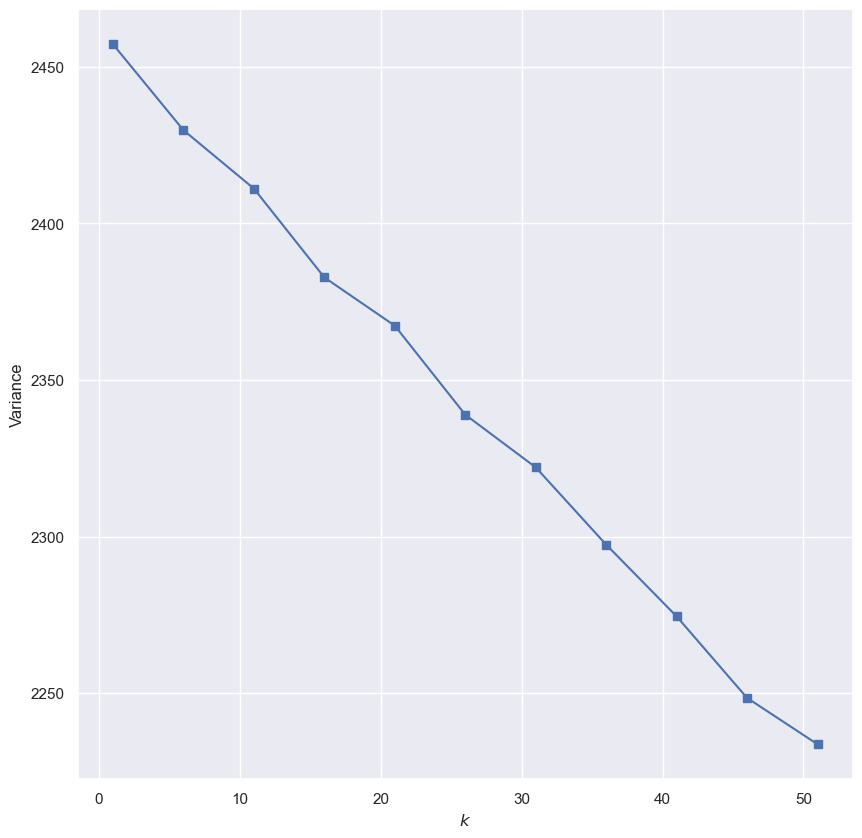

In [37]:
plt.plot(range(1, max_k, k_steps), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('Variance')

There is an elbow around 30-35 so I will try both a k of 35 and a k value that represents the same number of unique binned mpg values I have

In [38]:
k = len(y.unique())
#
# k = 35

print(f'Using k = {k}')

kmeans = KMeans(n_clusters=k, random_state=66).fit(x)

Using k = 10


In [39]:
kmeans_y = kmeans.fit_predict(x)

<AxesSubplot: xlabel='vf_ModelYear', ylabel='comb08'>

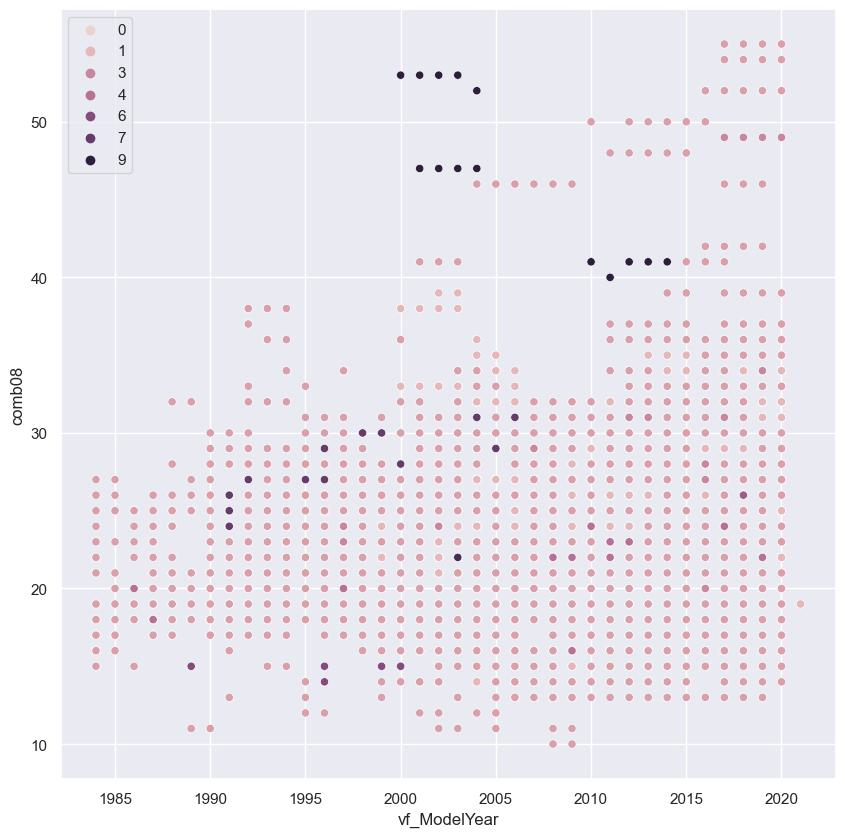

In [40]:
# what have we done...
colms = comb_df['brandName'].unique()
sns_markers = tuple([pairs for pairs in zip(colms, range(1,len(colms)+1), np.zeros(len(colms), dtype = int))])


sns.scatterplot(x=pd.DataFrame(scaler.inverse_transform(x, copy=True),columns=x.columns)['vf_ModelYear'],
                y=comb_df['comb08'], 
                hue=kmeans_y,#comb_df['brandName'],
               #palette = sns.color_palette('gist_ncar'), # markers arg https://matplotlib.org/3.1.1/api/markers_api.html
               markers=sns_markers # https://matplotlib.org/stable/api/markers_api.html
               )

Time to add a variable for the clusters back into x and then try our rf again!

In [41]:
x = pd.concat([x, pd.DataFrame(data = kmeans_y, columns = ['cluster'])], axis = 1)
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 66, train_size = 0.8)

In [42]:
cluster1_rf = RandomForestClassifier(n_estimators = 30, n_jobs=-1, random_state=66).fit(train_x,train_y)

In [43]:
print(cluster1_rf.score(test_x, test_y))

0.8211252653927813


Well, slightly worse... 
So let's optimize this Random Forest using grid search!

In [44]:
params = {#'n_estimators': list(range(1,len(x.columns), 300)),
            'max_features': ['sqrt',' None'],
            'criterion': ['gini', 'entropy'],
            'random_state': [66]
        }

rf_grid = GridSearchCV(RandomForestClassifier(), param_grid=params, n_jobs=-1, return_train_score=True, verbose=2)
rf_grid.fit(x,y)

print('Train Accuracy : %.3f'%rf_grid.best_estimator_.score(x, y))
print('Test Accuracy : %.3f'%rf_grid.best_estimator_.score(test_x, test_y))
print('Best Accuracy Through Grid Search : %.3f'%rf_grid.best_score_)
print('Best Parameters : ', rf_grid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\Matt\mambaforge\envs\DTSC\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Matt\mambaforge\envs\DTSC\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matt\mambaforge\envs\DTSC\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\Matt\mambaforge\envs\DTSC\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Us

Train Accuracy : 0.903
Test Accuracy : 0.912
Best Accuracy Through Grid Search : 0.767
Best Parameters :  {'criterion': 'entropy', 'max_features': 'sqrt', 'random_state': 66}


In [45]:
best_rf = RandomForestClassifier(criterion = 'entropy', max_features = 'sqrt', n_estimators = 211, random_state = 66, n_jobs = -1).fit(train_x,train_y)
print(cluster1_rf.score(test_x, test_y))

0.8211252653927813


I suppose the best RandomForest accuracy is destined to be ~82%.

## Storytelling (Clustering Analysis)
Use this section to further analyze your clusters.

What information or insights does it tell you? What have you learned? Were you able to answer your initial problems/questions (if so, discuss that)?

## Impact Section
Discuss the possible impact of your project. This can be socially, ethically, etc. It cannot be something like "our project has no impact" or "our project has no negative impact." Even the most well-intentioned projects *could* have a negative impact. We will not be checking for "right" or "wrong" answers, but showing your critical thinking.

## References
Include any references.

## Code
Make sure to include your code somehow as well. You can do this in various ways. For example, you can include code snippets throughout your writing and/or include a link to your Jupyter notebook file.